# Installing Dependencies

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/drw-crypto-market-prediction/sample_submission.csv
/kaggle/input/drw-crypto-market-prediction/train.parquet
/kaggle/input/drw-crypto-market-prediction/test.parquet


In [2]:
pip install pyarrow --quiet

Note: you may need to restart the kernel to use updated packages.


In [3]:
import torch
import random
from statsmodels.tsa.seasonal import seasonal_decompose


In [4]:
import pandas_datareader.data as web
import statsmodels.tsa.api as tsa
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.stattools import adfuller , acf , q_stat
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
plt.style.use('ggplot')

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


# **train.parquet** 
`The training dataset containing all historical market data along with the corresponding labels.`

* `timestamp`: The timestamp index representing the minute associated with each row.
* `bid_qty`: The total quantity buyers are willing to purchase at the best (highest) bid price at the given timestamp.
* `ask_qty`: The total quantity sellers are offering to sell at the best (lowest) ask price at the given timestamp.
* `buy_qty`: The total trading quantity executed at the best ask price during the given minute.
* `sell_qty`: The total trading quantity executed at the best bid price during the given minute.
* `volume`: The total traded volume during the minute.
* `X_{1,...,890}`: A set of anonymized market features derived from proprietary data sources.
* `label`: The target variable representing the anonymized market price movement to be predicted.

In [6]:
# Reading the table train.parquet

import pyarrow.parquet as pa
df = pa.read_table('/kaggle/input/drw-crypto-market-prediction/train.parquet')
df = df.to_pandas()
df.head()

,bid_qty,ask_qty,buy_qty,sell_qty,volume,X1,X2,X3,X4,X5,...,X882,X883,X884,X885,X886,X887,X888,X889,X890,label
timestamp,,,,,,,,,,,,,,,,,,,,,
2023-03-01 00:00:00,15.283,8.425,176.405,44.984,221.389,0.121263,-0.417690,0.005399,0.125948,0.058359,...,1.925423,1.847943,0.005676,0.190791,0.369691,0.377630,0.210153,0.159183,0.530636,0.562539
2023-03-01 00:01:00,38.590,2.336,525.846,321.950,847.796,0.302841,-0.049576,0.356667,0.481087,0.237954,...,1.928569,1.849468,0.005227,0.184660,0.363642,0.374515,0.209573,0.158963,0.530269,0.533686
2023-03-01 00:02:00,0.442,60.250,159.227,136.369,295.596,0.167462,-0.291212,0.083138,0.206881,0.101727,...,1.928047,1.849282,0.004796,0.178719,0.357689,0.371424,0.208993,0.158744,0.529901,0.546505
2023-03-01 00:03:00,4.865,21.016,335.742,124.963,460.705,0.072944,-0.436590,-0.102483,0.017551,0.007149,...,1.928621,1.849608,0.004398,0.172967,0.351832,0.368358,0.208416,0.158524,0.529534,0.357703
2023-03-01 00:04:00,27.158,3.451,98.411,44.407,142.818,0.173820,-0.213489,0.096067,0.215709,0.107133,...,1.927084,1.848950,0.004008,0.167391,0.346066,0.365314,0.207839,0.158304,0.529167,0.362452


In [7]:
df['ID'] = range(1, len(df) + 1)

In [8]:
#df.set_index('ID' , inplace = True)

In [9]:
df.head()

,bid_qty,ask_qty,buy_qty,sell_qty,volume,X1,X2,X3,X4,X5,...,X883,X884,X885,X886,X887,X888,X889,X890,label,ID
timestamp,,,,,,,,,,,,,,,,,,,,,
2023-03-01 00:00:00,15.283,8.425,176.405,44.984,221.389,0.121263,-0.417690,0.005399,0.125948,0.058359,...,1.847943,0.005676,0.190791,0.369691,0.377630,0.210153,0.159183,0.530636,0.562539,1
2023-03-01 00:01:00,38.590,2.336,525.846,321.950,847.796,0.302841,-0.049576,0.356667,0.481087,0.237954,...,1.849468,0.005227,0.184660,0.363642,0.374515,0.209573,0.158963,0.530269,0.533686,2
2023-03-01 00:02:00,0.442,60.250,159.227,136.369,295.596,0.167462,-0.291212,0.083138,0.206881,0.101727,...,1.849282,0.004796,0.178719,0.357689,0.371424,0.208993,0.158744,0.529901,0.546505,3
2023-03-01 00:03:00,4.865,21.016,335.742,124.963,460.705,0.072944,-0.436590,-0.102483,0.017551,0.007149,...,1.849608,0.004398,0.172967,0.351832,0.368358,0.208416,0.158524,0.529534,0.357703,4
2023-03-01 00:04:00,27.158,3.451,98.411,44.407,142.818,0.173820,-0.213489,0.096067,0.215709,0.107133,...,1.848950,0.004008,0.167391,0.346066,0.365314,0.207839,0.158304,0.529167,0.362452,5


## Shape of Data : (525887, 896)

# Random-Sampling to Visalize

* Random Sample is a sample drawn out of the parent dataset without replacement
* It is meant to be a good estimator of the parent dataset

In [10]:
a , b , n = 0 , df.shape[0] , 1000

random_numbers = random.sample(range(a, b + 1), n)
# print(random_numbers)

In [11]:
df_sample = df[df['ID'].isin(random_numbers)]

In [12]:
df_sample['label'].mean

<bound method Series.mean of timestamp
2023-03-01 03:12:00    2.374490
2023-03-01 07:43:00    0.437805
2023-03-01 15:40:00   -0.628068
2023-03-01 19:19:00   -1.870402
2023-03-02 18:22:00    1.322785
                         ...   
2024-02-29 04:10:00    2.714067
2024-02-29 06:07:00    0.403754
2024-02-29 15:07:00   -0.541388
2024-02-29 19:37:00    0.633462
2024-02-29 21:29:00   -0.073646
Name: label, Length: 1000, dtype: float64>

## Plots

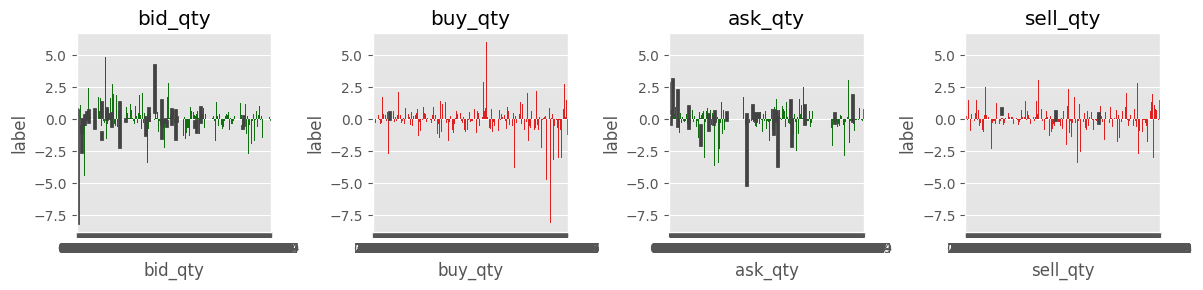

In [13]:
fig, axs = plt.subplots(1, 4, figsize=(12, 3),alpha=1)
sns.barplot(data=df_sample, x='bid_qty', y='label', color ='green' , ax=axs[0])
sns.barplot(data=df_sample, x='buy_qty', y='label', color = 'red' , ax=axs[1])
sns.barplot(data=df_sample, x='ask_qty', y='label',color ='green', ax=axs[2])
sns.barplot(data=df_sample, x='sell_qty', y='label',color = 'red', ax=axs[3])
axs[0].set_title('bid_qty')
axs[1].set_title('buy_qty')
axs[2].set_title('ask_qty')
axs[3].set_title('sell_qty')
plt.tight_layout()
plt.show()

/tmp/ipykernel_13/1958036484.py:1: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


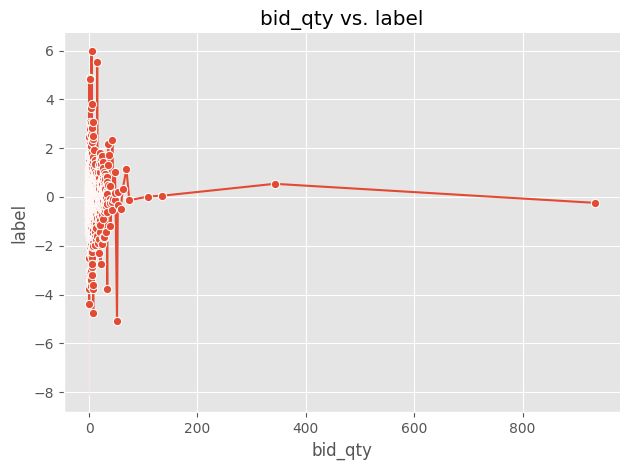

In [14]:
with pd.option_context('mode.use_inf_as_na', True):
   sns.lineplot(data=df_sample,x='bid_qty',y='label' , marker = 'o')
   sns.set_style('whitegrid')
   plt.gca().spines[['top', 'right']].set_visible(False)
   plt.xlabel('bid_qty')
   plt.ylabel('label')
   plt.title('bid_qty vs. label')
   plt.tight_layout()
   plt.show()

In [15]:
df_sample = df_sample.reset_index(drop=False)

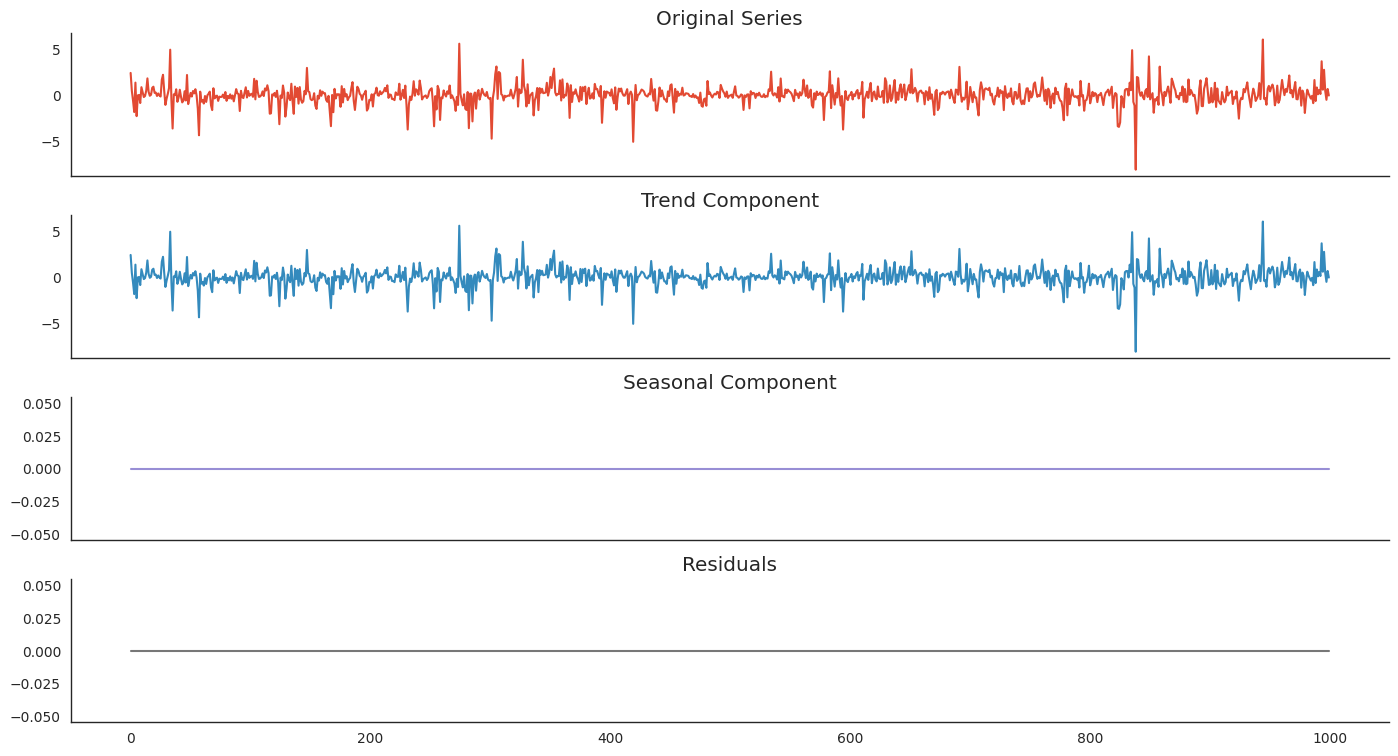

In [16]:
# cols = ['bid_qty', 'ask_qty', 'buy_qty', 'sell_qty']
# for col in cols : 
components = tsa.seasonal_decompose(df_sample['label'], model='additive' , period =1 )
    
ts = (df_sample['label'].to_frame('Original')
      .assign(Trend=components.trend)
      .assign(Seasonality=components.seasonal)
      .assign(Residual=components.resid))
with sns.axes_style('white'):
    ts.plot(subplots=True, figsize=(14, 8), title=['Original Series', 'Trend Component', 'Seasonal Component','Residuals'], legend=False)
    #plt.suptitle('Data Trends', fontsize=14)
    sns.despine()
    plt.tight_layout()
    plt.subplots_adjust(top=.91)

**Inferences**
* This data seems to have uniform mean over time in terms of bid_quantity , ask_quantity , buy_quantity , sell_quantity
* Seasonal Decomposition reveals that `label` column has no seasonal or residual patterns.